In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
#imports for data cleaning
import string
import regex
#Library imports
import pandas as pd 
from pylab import rcParams

from sklearn import metrics
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import precision_score, recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,classification_report
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
df = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")

In [4]:
xgb_df = df.copy()

In [5]:
xgb_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
#removes links,special characters,usernames,numbers, punctuations
def clean_text(text):
    result = regex.sub(r'http[^\s]*', '',text)
    result = regex.sub('[0-9]+','', result).lower()
    result = regex.sub('@[a-z0-9]+', 'user', result)
    return regex.sub('[%s]*' % string.punctuation, '',result)

In [7]:
xgb_df["cleaned_posts"] = xgb_df["posts"].apply(clean_text)

In [8]:
xgb_df.head()

,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten ...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know tha...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...


In [9]:
cv = CountVectorizer(stop_words = ['and','the','to','of',
                                           'infj','entp','intp','intj',
                                           'entj','enfj','infp','enfp',
                                           'isfp','istp','isfj','istj',
                                           'estp','esfp','estj','esfj',
                                           'infjs','entps','intps','intjs',
                                           'entjs','enfjs','infps','enfps',
                                           'isfps','istps','isfjs','istjs',
                                           'estps','esfps','estjs','esfjs'],max_features = 2000,analyzer="word")

#stopwords = words that will be removed
#max_features = The CountVectorizer will choose the words/features that occur most frequently to be in its' vocabulary and drop everything else.
#min_df,max_df = min,max doc frequency words must have to bee considered a feature

In [10]:
corpus = xgb_df['cleaned_posts'].values.reshape(1,-1).tolist()[0]
cv.fit(corpus)
count = cv.fit_transform(corpus)

In [11]:
count

<8675x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 3043075 stored elements in Compressed Sparse Row format>

In [12]:
# Transform the count matrix to a tf-idf representation
tfizer = TfidfTransformer()
tfizer.fit(count)
X = tfizer.fit_transform(count).toarray()

In [13]:
X.shape

(8675, 2000)

In [14]:
words = cv.get_feature_names_out()
numberWords = len(words)
words

array(['ability', 'able', 'about', ..., 'youtube', 'youve', 'zone'],
      dtype=object)

In [15]:
X_df = pd.DataFrame.from_dict({w: X[:, i] for i, w in enumerate(words)}) 

In [16]:
xgb_df['I-E'] = xgb_df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
xgb_df['N-S'] = xgb_df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
xgb_df['T-F'] = xgb_df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
xgb_df['J-P'] = xgb_df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

In [17]:
xgb_df.head()

,type,posts,cleaned_posts,I-E,N-S,T-F,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten ...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know tha...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...,1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...,0,1,0,0


##XGBClassifier

In [18]:
#E
y_f_e = xgb_df['I-E'].values  
xe_train, xe_test, ye_train, ye_test = train_test_split(X_df, y_f_e,test_size=0.2,stratify=y_f_e)
fe_classifier = XGBClassifier()
print(">>> Train classifier ... ")
fe_classifier.fit(xe_train, ye_train,verbose=False)
print(">>> Finish training")




>>> Train classifier ... 
>>> Finish training


In [19]:
print("Training Accuracy " , accuracy_score(ye_train, fe_classifier.predict(xe_train)))
print("AUC ", roc_auc_score(ye_train, fe_classifier.predict_proba(xe_train)[:,1]))
print("Precision " , precision_score(ye_train, fe_classifier.predict(xe_train)))
print("Recall " , recall_score(ye_train, fe_classifier.predict(xe_train)))
print("F1 score " ,f1_score(ye_train, fe_classifier.predict(xe_train)))

Training Accuracy  0.8077809798270893
AUC  0.9240733799759469
Precision  0.8007806635640294
Recall  0.9986893840104849
F1 score  0.8888518580236627


In [20]:
print("Testing Accuracy " , accuracy_score(ye_test, fe_classifier.predict(xe_test)))
print("AUC ", roc_auc_score(ye_test, fe_classifier.predict_proba(xe_test)[:,1]))
print("Precision " , precision_score(ye_test, fe_classifier.predict(xe_test)))
print("Recall " , recall_score(ye_test, fe_classifier.predict(xe_test)))
print("F1 score " ,f1_score(ye_test, fe_classifier.predict(xe_test)))

Testing Accuracy  0.7769452449567723
AUC  0.7193426966292136
Precision  0.7778429073856975
Recall  0.9940074906367041
F1 score  0.8727392305162776


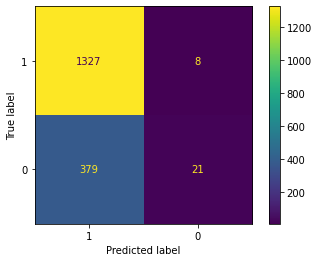

In [39]:
ConfusionMatrixDisplay.from_predictions(ye_test,fe_classifier.predict(xe_test),labels=[1,0])


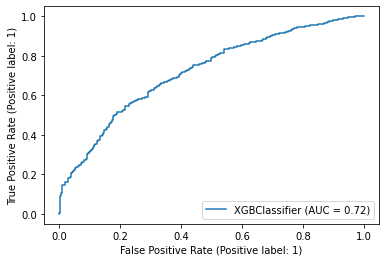

In [40]:
RocCurveDisplay.from_estimator(fe_classifier, xe_test, ye_test)

In [23]:
#S
y_f_s = xgb_df['N-S'].values  
xs_train, xs_test, ys_train, ys_test = train_test_split(X_df, y_f_s,test_size=0.2,stratify=y_f_s)
fs_classifier = XGBClassifier()
print(">>> Train classifier ... ")
fs_classifier.fit(xs_train, ys_train,verbose=False)
print(">>> Finish training")

>>> Train classifier ... 
>>> Finish training


In [24]:
print("Training Accuracy " , accuracy_score(ys_train, fs_classifier.predict(xs_train)))
print("AUC ", roc_auc_score(ys_train, fs_classifier.predict_proba(xs_train)[:,1]))
print("Precision " , precision_score(ys_train, fs_classifier.predict(xs_train)))
print("Recall " , recall_score(ys_train, fs_classifier.predict(xs_train)))
print("F1 score " ,f1_score(ys_train, fs_classifier.predict(xs_train)))

Training Accuracy  0.8731988472622478
AUC  0.9559241398517055
Precision  0.8717575051005537
Recall  1.0
F1 score  0.9314855185300529


In [25]:
print("Testing Accuracy " , accuracy_score(ys_test, fs_classifier.predict(xs_test)))
print("AUC ", roc_auc_score(ys_test, fs_classifier.predict_proba(xs_test)[:,1]))
print("Precision " , precision_score(ys_test, fs_classifier.predict(xs_test)))
print("Recall " , recall_score(ys_test, fs_classifier.predict(xs_test)))
print("F1 score " ,f1_score(ys_test, fs_classifier.predict(xs_test)))

Testing Accuracy  0.8610951008645533
AUC  0.7014828944129954
Precision  0.8620888632429313
Recall  0.9986631016042781
F1 score  0.9253638897491484


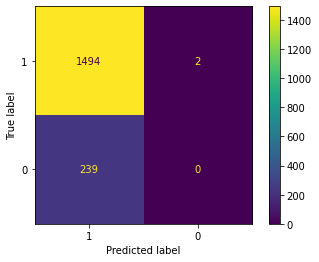

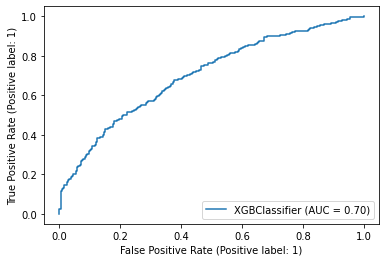

In [26]:
ConfusionMatrixDisplay.from_predictions(ys_test,fs_classifier.predict(xs_test),labels=[1,0])
RocCurveDisplay.from_estimator(fs_classifier, xs_test, ys_test)

In [27]:
#T
y_f_t = xgb_df['T-F'].values  
xt_train, xt_test, yt_train, yt_test = train_test_split(X_df, y_f_t,test_size=0.2,stratify=y_f_t)
ft_classifier = XGBClassifier()
print(">>> Train classifier ... ")
ft_classifier.fit(xt_train, yt_train,verbose=False)
print(">>> Finish training")

>>> Train classifier ... 
>>> Finish training


In [28]:
print("Accuracy " , accuracy_score(yt_train, ft_classifier.predict(xt_train)))
print("AUC ", roc_auc_score(yt_train, ft_classifier.predict_proba(xt_train)[:,1]))
print("Precision " , precision_score(yt_train, ft_classifier.predict(xt_train)))
print("Recall " , recall_score(yt_train, ft_classifier.predict(xt_train)))
print("F1 score " ,f1_score(yt_train, ft_classifier.predict(xt_train)))

Accuracy  0.8350144092219021
AUC  0.9191376437904877
Precision  0.8407310704960835
Recall  0.8575233022636485
F1 score  0.8490441661173368


In [29]:
print("Accuracy " , accuracy_score(yt_test, ft_classifier.predict(xt_test)))
print("AUC ", roc_auc_score(yt_test, ft_classifier.predict_proba(xt_test)[:,1]))
print("Precision " , precision_score(yt_test, ft_classifier.predict(xt_test)))
print("Recall " , recall_score(yt_test, ft_classifier.predict(xt_test)))
print("F1 score " ,f1_score(yt_test, ft_classifier.predict(xt_test)))

Accuracy  0.7285302593659942
AUC  0.8176104162987462
Precision  0.7427385892116183
Recall  0.7625133120340788
F1 score  0.7524960588544404


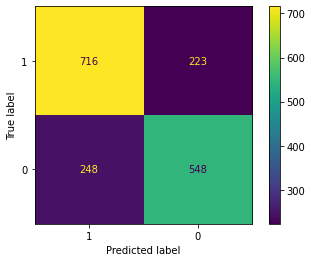

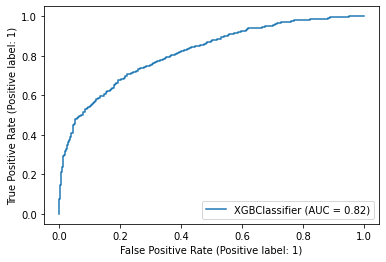

In [31]:
ConfusionMatrixDisplay.from_predictions(yt_test,ft_classifier.predict(xt_test),labels=[1,0])
RocCurveDisplay.from_estimator(ft_classifier, xt_test, yt_test)

In [32]:
#J
y_f_j = xgb_df['J-P'].values  
xj_train, xj_test, yj_train, yj_test = train_test_split(X_df, y_f_j,test_size=0.2,stratify=y_f_j)
fj_classifier = XGBClassifier()
print(">>> Train classifier ... ")
fj_classifier.fit(xj_train, yj_train,verbose=False)
print(">>> Finish training")

>>> Train classifier ... 
>>> Finish training


In [33]:
print("Accuracy " , accuracy_score(yj_train, fj_classifier.predict(xj_train)))
print("AUC ", roc_auc_score(yj_train, fj_classifier.predict_proba(xj_train)[:,1]))
print("Precision " , precision_score(yj_train, fj_classifier.predict(xj_train)))
print("Recall " , recall_score(yj_train, fj_classifier.predict(xj_train)))
print("F1 score " ,f1_score(yj_train, fj_classifier.predict(xj_train)))

Accuracy  0.7600864553314121
AUC  0.8835833397507294
Precision  0.7304886943836616
Recall  0.9554018602432626
F1 score  0.8279425441769144


In [34]:
print("Accuracy " , accuracy_score(yj_test, fj_classifier.predict(xj_test)))
print("AUC ", roc_auc_score(yj_test, fj_classifier.predict_proba(xj_test)[:,1]))
print("Precision " , precision_score(yj_test, fj_classifier.predict(xj_test)))
print("Recall " , recall_score(yj_test, fj_classifier.predict(xj_test)))
print("F1 score " ,f1_score(yj_test, fj_classifier.predict(xj_test)))

Accuracy  0.6610951008645534
AUC  0.6873923575230285
Precision  0.6654676258992805
Recall  0.8826335877862596
F1 score  0.7588187038556193


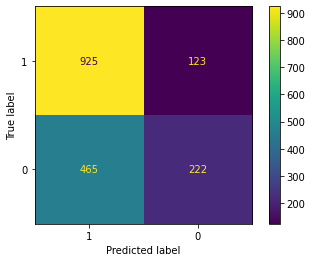

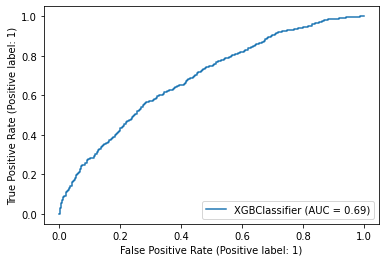

In [35]:
ConfusionMatrixDisplay.from_predictions(yj_test,fj_classifier.predict(xj_test),labels=[1,0])
RocCurveDisplay.from_estimator(fj_classifier, xj_test, yj_test)

In [ ]:
test_string = "I’m a very social person, and I get a lot of energy from interacting with people. They definitely describe me as an extrovert, because I don’t stop talking. People would characterize me as a pretty open person...for example, I can easily strike up a conversation with a stranger. It depends on the people I’m hanging out with. With the general public, for example, at a party, I would say a few hours. But typically, it would take a day or two until I need downtime. I recharge by sleeping or watching Netflix by myself. However, I’m personally not very good at being alone, which is something I’m still trying to grasp. Usually, I would prefer to hang out with friends or engage with something externally, just so I don’t have to hear my own thoughts. I’m very at ease about it…but sometimes, I wish I wasn’t. Like, oops, maybe I shouldn’t have said that because it was TMI. But I feel like, if I’m not presenting my true self to someone, then what am I embarrassed about? I’m pretty secure in the stuff I bring, good and bad, so if you accept it, great. If not, then we don’t need to be friends. I don’t like small talk because it feels shallow and surface level. It’s nice, pleasantries and such, but I can’t do just casual relationships or friendships. I much prefer deep talks, like tell me your insecurities and fears and all that.".lower()
final_test = tfizer.transform(cv.transform([test_string])).toarray()

In [ ]:
test_point = pd.DataFrame.from_dict({w: final_test[:, i] for i, w in enumerate(words)})

In [ ]:
fe_classifier.predict_proba(test_point) #[I, E]

array([[0.16452688, 0.8354731 ]], dtype=float32)

In [ ]:
fs_classifier.predict_proba(test_point) #[N,S]

array([[0.21989518, 0.7801048 ]], dtype=float32)

In [ ]:
ft_classifier.predict_proba(test_point) #[F,T]

array([[0.5564865 , 0.44351348]], dtype=float32)

In [ ]:
fj_classifier.predict_proba(test_point) #[P,J]

array([[0.33492655, 0.66507345]], dtype=float32)

##Random Forest

In [ ]:
rf_df = df.copy()

In [ ]:
rf_df["cleaned_posts"] = rf_df["posts"].apply(clean_text)

In [ ]:
rf_df.head()

,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and intj moments sportscenter not top ten ...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course to which i say i know tha...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp i enjoyed our conversation the oth...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception t...


In [ ]:
## Random Forest ###########################################################################
random_foresttIE = RandomForestClassifier(n_estimators=20)
random_foresttIE.fit(xe_train,ye_train)
print('Training Accuracy',accuracy_score(ye_train,random_foresttIE.predict(xe_train)))
print('Testing Accuracy',accuracy_score(ye_test,random_foresttIE.predict(xe_test)))
print(classification_report(ye_test, random_foresttIE.predict(xe_test)))
ConfusionMatrixDisplay.from_estimator(random_foresttIE,xe_test,ye_test,labels=[1,0])
RocCurveDisplay.from_estimator(random_foresttIE, xe_train,ye_train)

RF score train 99.8127 %
RF score test 88.415 %
              precision    recall  f1-score   support

           0       0.83      0.07      0.13       213
           1       0.88      1.00      0.94      1522

    accuracy                           0.88      1735
   macro avg       0.86      0.53      0.53      1735
weighted avg       0.88      0.88      0.84      1735



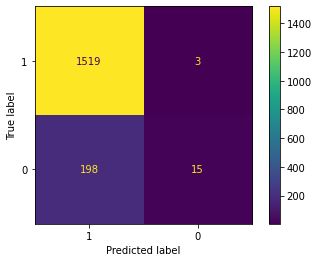

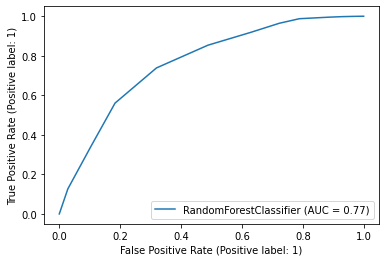

In [ ]:
random_foresttNS = RandomForestClassifier(n_estimators=20)
random_foresttNS.fit(features_train,NS_train)
acc_rff_train = round(random_foresttNS.score(features_train,NS_train) * 100, 4)
acc_rff_test = round(random_foresttNS.score(features_test,NS_test) * 100, 4)
print('RF score train',acc_rff_train, "%")
print('RF score test',acc_rff_test, "%")
print(classification_report(NS_test, random_foresttNS.predict(features_test)))
ConfusionMatrixDisplay.from_estimator(random_foresttNS,features_test,NS_test,labels=[1,0])
RocCurveDisplay.from_estimator(random_foresttNS, features_test,NS_test)

RF score train 99.9712 %
RF score test 73.5447 %
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       799
           1       0.76      0.74      0.75       936

    accuracy                           0.74      1735
   macro avg       0.73      0.73      0.73      1735
weighted avg       0.74      0.74      0.74      1735



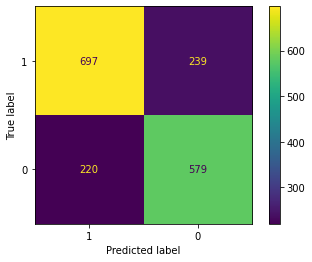

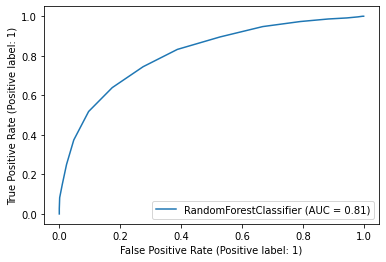

In [ ]:
random_foresttTF = RandomForestClassifier(n_estimators=20)
random_foresttTF.fit(features_train,TF_train)
acc_rff_train = round(random_foresttTF.score(features_train,TF_train) * 100, 4)
acc_rff_test = round(random_foresttTF.score(features_test,TF_test) * 100, 4)
print('RF score train',acc_rff_train, "%")
print('RF score test',acc_rff_test, "%")
print(classification_report(TF_test, random_foresttTF.predict(features_test)))
ConfusionMatrixDisplay.from_estimator(random_foresttTF,features_test,TF_test,labels=[1,0])
RocCurveDisplay.from_estimator(random_foresttTF, features_test,TF_test)

RF score train 99.9712 %
RF score test 71.7003 %
              precision    recall  f1-score   support

           0       0.69      0.52      0.60       692
           1       0.73      0.84      0.78      1043

    accuracy                           0.72      1735
   macro avg       0.71      0.68      0.69      1735
weighted avg       0.71      0.72      0.71      1735



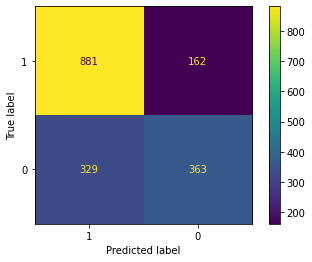

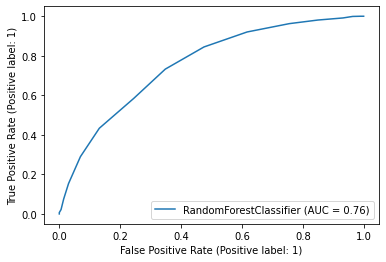

In [ ]:
random_foresttJP = RandomForestClassifier(n_estimators=20)
random_foresttJP.fit(features_train,JP_train)
acc_rff_train = round(random_foresttJP.score(features_train,JP_train) * 100, 4)
acc_rff_test = round(random_foresttJP.score(features_test,JP_test) * 100, 4)
print('RF score train',acc_rff_train, "%")
print('RF score test',acc_rff_test, "%")
print(classification_report(JP_test, random_foresttJP.predict(features_test)))
ConfusionMatrixDisplay.from_estimator(random_foresttJP,features_test,JP_test,labels=[1,0])
RocCurveDisplay.from_estimator(random_foresttJP, features_test,JP_test)